In [23]:
#importing libs
import numpy as np
import matplotlib.pyplot as plt
import glob
from data_gen import *
from predict_info import *

import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Dense, Flatten, Input, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D, BatchNormalization, ZeroPadding1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix


from tensorflow.config.experimental import list_physical_devices, set_virtual_device_configuration, VirtualDeviceConfiguration

gpus = list_physical_devices('GPU')
set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=6000)])#
print(len(gpus), "Physical GPUs")   

1 Physical GPUs


In [2]:
df = pd.read_csv("Data/scaled_xyzlog_without_GRBs.csv", index_col=0) # data (hopefuly without grbs)
df

/home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,time,x,y,z,log_cps
0,481.489854,0.351577,-0.470408,-0.809389,1.981139
1,481.489901,0.402253,-0.651949,-0.642771,1.985651
2,481.489947,0.402425,-0.804490,-0.436865,1.984527
3,481.489993,0.359273,-0.910516,-0.204654,2.024280
4,481.490039,0.284601,-0.957816,0.039879,1.973128
...,...,...,...,...,...
2054802,719.491781,-0.080000,0.068985,0.994405,2.120574
2054803,719.491793,-0.125928,0.111252,0.985782,2.130334
2054804,719.491804,-0.170043,0.154518,0.973247,2.152288
2054805,719.491816,-0.212694,0.197985,0.956851,2.176091


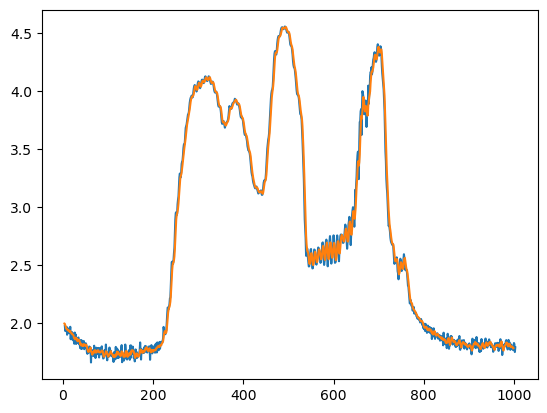

In [3]:
rollWindowSize = 4
rollWindow = df['log_cps'].rolling(rollWindowSize)
rollAvr = rollWindow.mean()
plt.plot(df['log_cps'][rollWindowSize:1000+rollWindowSize])
plt.plot(rollAvr[0:1000])
df['log_cps'] = rollAvr

In [4]:
df

,time,x,y,z,log_cps
0,481.489854,0.351577,-0.470408,-0.809389,NaN
1,481.489901,0.402253,-0.651949,-0.642771,NaN
2,481.489947,0.402425,-0.804490,-0.436865,NaN
3,481.489993,0.359273,-0.910516,-0.204654,1.993899
4,481.490039,0.284601,-0.957816,0.039879,1.991897
...,...,...,...,...,...
2054802,719.491781,-0.080000,0.068985,0.994405,2.154808
2054803,719.491793,-0.125928,0.111252,0.985782,2.150859
2054804,719.491804,-0.170043,0.154518,0.973247,2.153178
2054805,719.491816,-0.212694,0.197985,0.956851,2.144822


In [5]:
df = df.drop(df.index[:rollWindowSize-1])
df

,time,x,y,z,log_cps
3,481.489993,0.359273,-0.910516,-0.204654,1.993899
4,481.490039,0.284601,-0.957816,0.039879,1.991897
5,481.490086,0.191439,-0.940405,0.281052,1.977839
6,481.490132,0.098804,-0.856678,0.506301,1.970869
7,481.490178,0.021979,-0.712759,0.701065,1.950611
...,...,...,...,...,...
2054802,719.491781,-0.080000,0.068985,0.994405,2.154808
2054803,719.491793,-0.125928,0.111252,0.985782,2.150859
2054804,719.491804,-0.170043,0.154518,0.973247,2.153178
2054805,719.491816,-0.212694,0.197985,0.956851,2.144822


In [6]:
def df_to_X(df, windowSize=512):
    dfNumpy = df.to_numpy()
    X = []
    for i in range(len(dfNumpy)-windowSize):
        if abs(dfNumpy[i+windowSize][0] - (windowSize*(dfNumpy[i-1][0]-dfNumpy[i][0])+dfNumpy[i][0])) < 1:
            X.append(dfNumpy[i:i+windowSize,-1])
    return np.array(X, dtype=np.float32)

In [7]:
X = df_to_X(df,windowSize=512)
X = tf.random.shuffle(X, seed=420)

2023-05-02 13:56:08.776738: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 13:56:08.778021: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-02 13:56:08.778194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 13:56:08.778516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.83GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 46

In [8]:
splitIndex = int(len(X) * 0.8)
X_train, y_train, X_test, y_test = X[0:splitIndex],X[0:splitIndex],X[splitIndex:],X[splitIndex:]

In [9]:
np.shape(X_train[0])

TensorShape([512])

# Autoencoder

In [40]:
# Define model
def create_autoencoder():
    # Encoder
    inputs = Input(shape=(512,1))
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Flatten()(x)
    encoded = Dense(8,activation='relu')(x)
    
  
    # Decoder
    x = Dense(8,activation='relu')(encoded)
    x = Reshape((8,1))(x)
    x = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='sigmoid')(x)
    x = Flatten()(x)
    x = Dense(512,activation='relu')(x)
    decoded = Reshape((512,1))(x)
  
    # Define autoencoder
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return autoencoder


autoencoder = create_autoencoder()
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 1)]          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 512, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 256, 64)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 256, 8)            1544      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 128, 8)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 8200

In [11]:
fileName = '{}-{}-{}-{}'.format(datetime.datetime.today().month,
          datetime.datetime.today().day,
          datetime.datetime.today().hour,
          datetime.datetime.today().minute)
callback_conv = [EarlyStopping(monitor='val_loss', patience=4),
                 ModelCheckpoint("models/autoConv/{}.h5".format(fileName), 
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True, 
                                 mode='min'),
                ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,verbose=True,min_lr=0.0001),
                TensorBoard(log_dir = "./Tensor_logs/auto/{}".format(fileName), update_freq="epoch")]


history = autoencoder.fit(X_train, y_train,
          validation_data = (X_test, y_test),
          epochs=100, callbacks=[callback_conv],
                         shuffle=True)

2023-05-02 13:56:15.327595: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-02 13:56:15.327613: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-02 13:56:15.329378: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-05-02 13:56:15.344187: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-05-02 13:56:15.445610: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-05-02 13:56:15.447046: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-05-02 13:56:15.504693: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3312799744 exceeds 10% of free system memory.
2023-05-02 13:56:16.980054: W 

Epoch 1/100


2023-05-02 13:56:19.006291: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-02 13:56:19.592846: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


   44/50550 [..............................] - ETA: 3:26 - loss: 4.3349 

2023-05-02 13:56:22.234282: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-02 13:56:22.234314: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-02 13:56:22.235159: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-05-02 13:56:22.242409: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-05-02 13:56:22.244101: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-05-02 13:56:22.246219: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-05-02 13:56:22.253456: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./Tensor_logs/auto/5-2-13-56/train/plugins

50550/50550 [==============================] - 131s 3ms/step - loss: 2.0256 - val_loss: 0.3961

Epoch 00001: val_loss improved from inf to 0.39605, saving model to models/autoConv/5-2-13-56.h5
Epoch 2/100
50550/50550 [==============================] - 113s 2ms/step - loss: 0.3183 - val_loss: 0.2472

Epoch 00002: val_loss improved from 0.39605 to 0.24722, saving model to models/autoConv/5-2-13-56.h5
Epoch 3/100
50550/50550 [==============================] - 113s 2ms/step - loss: 0.2220 - val_loss: 0.1809

Epoch 00003: val_loss improved from 0.24722 to 0.18090, saving model to models/autoConv/5-2-13-56.h5
Epoch 4/100
50550/50550 [==============================] - 113s 2ms/step - loss: 0.1813 - val_loss: 0.1552

Epoch 00004: val_loss improved from 0.18090 to 0.15518, saving model to models/autoConv/5-2-13-56.h5
Epoch 5/100
50550/50550 [==============================] - 113s 2ms/step - loss: 0.1536 - val_loss: 0.1521

Epoch 00005: val_loss improved from 0.15518 to 0.15214, saving model to 

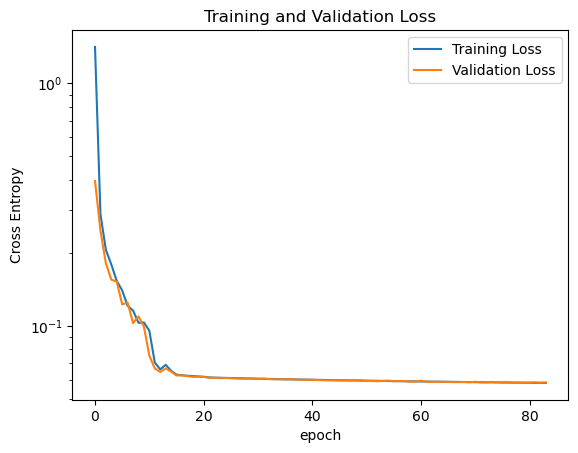

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.show()

In [13]:
X_pred = autoencoder.predict(X_test)
x = np.arange(len(X_test[0]))

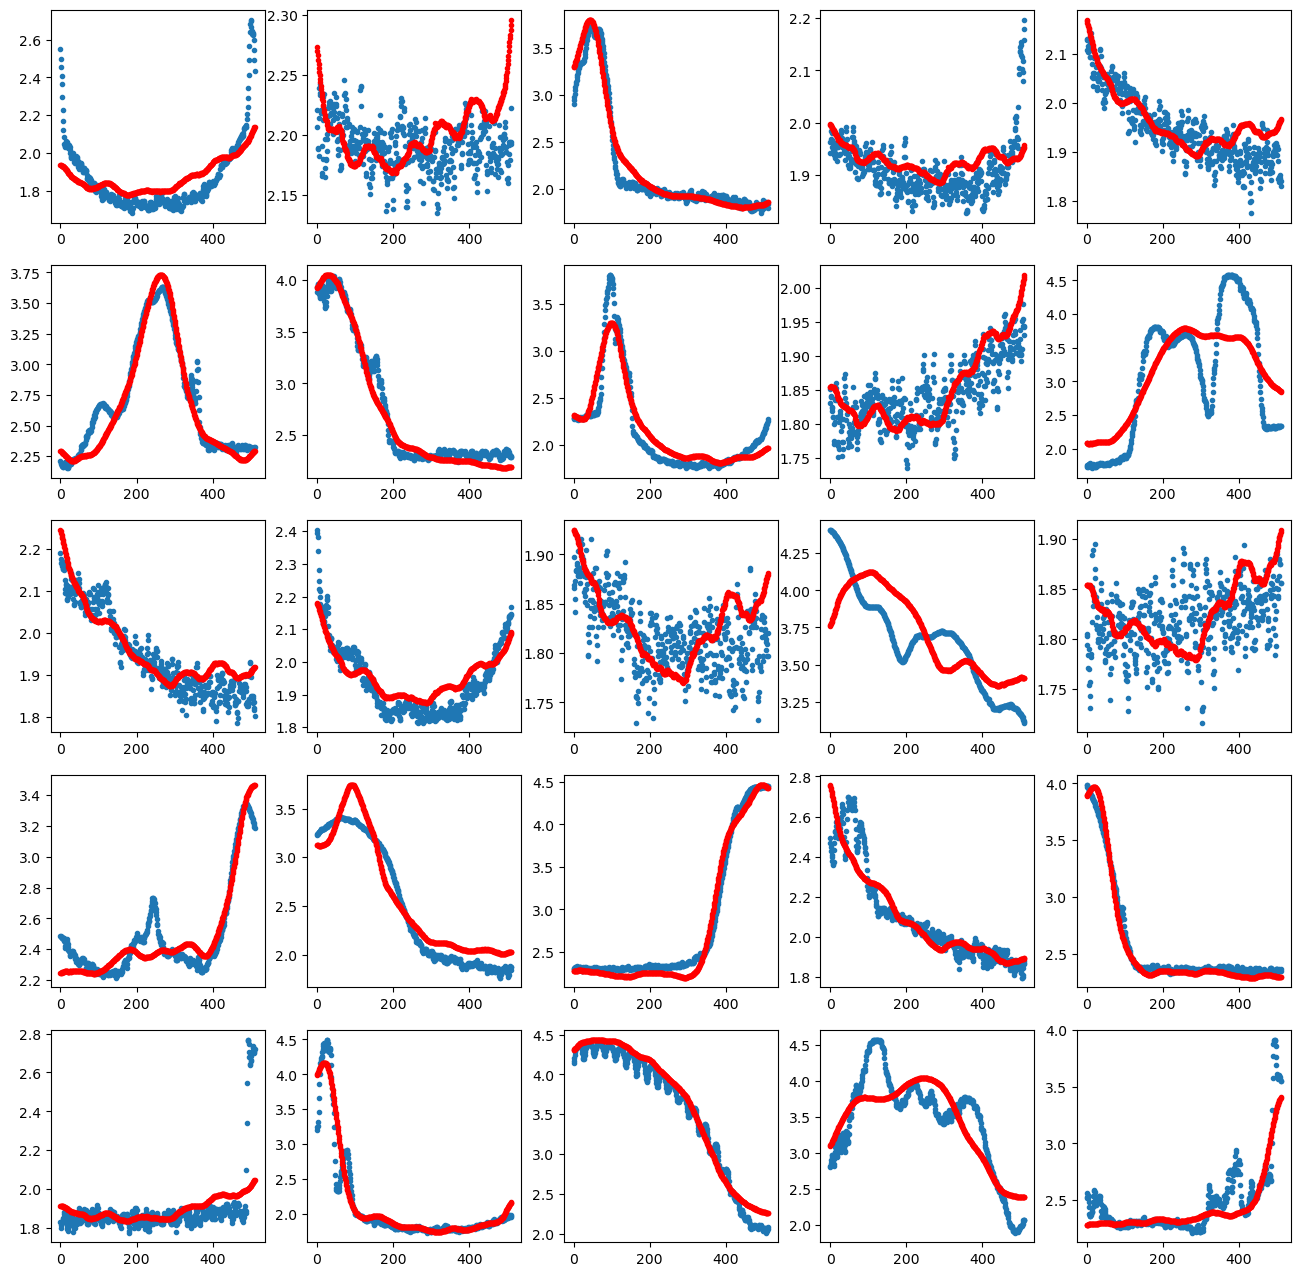

In [14]:
fig, axs = plt.subplots(5,5,figsize=(16,16))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(y_test))
        axs[i,j].scatter(x,X_test[ind],marker='.')
        axs[i,j].scatter(x,X_pred[ind],color="red",marker='.');

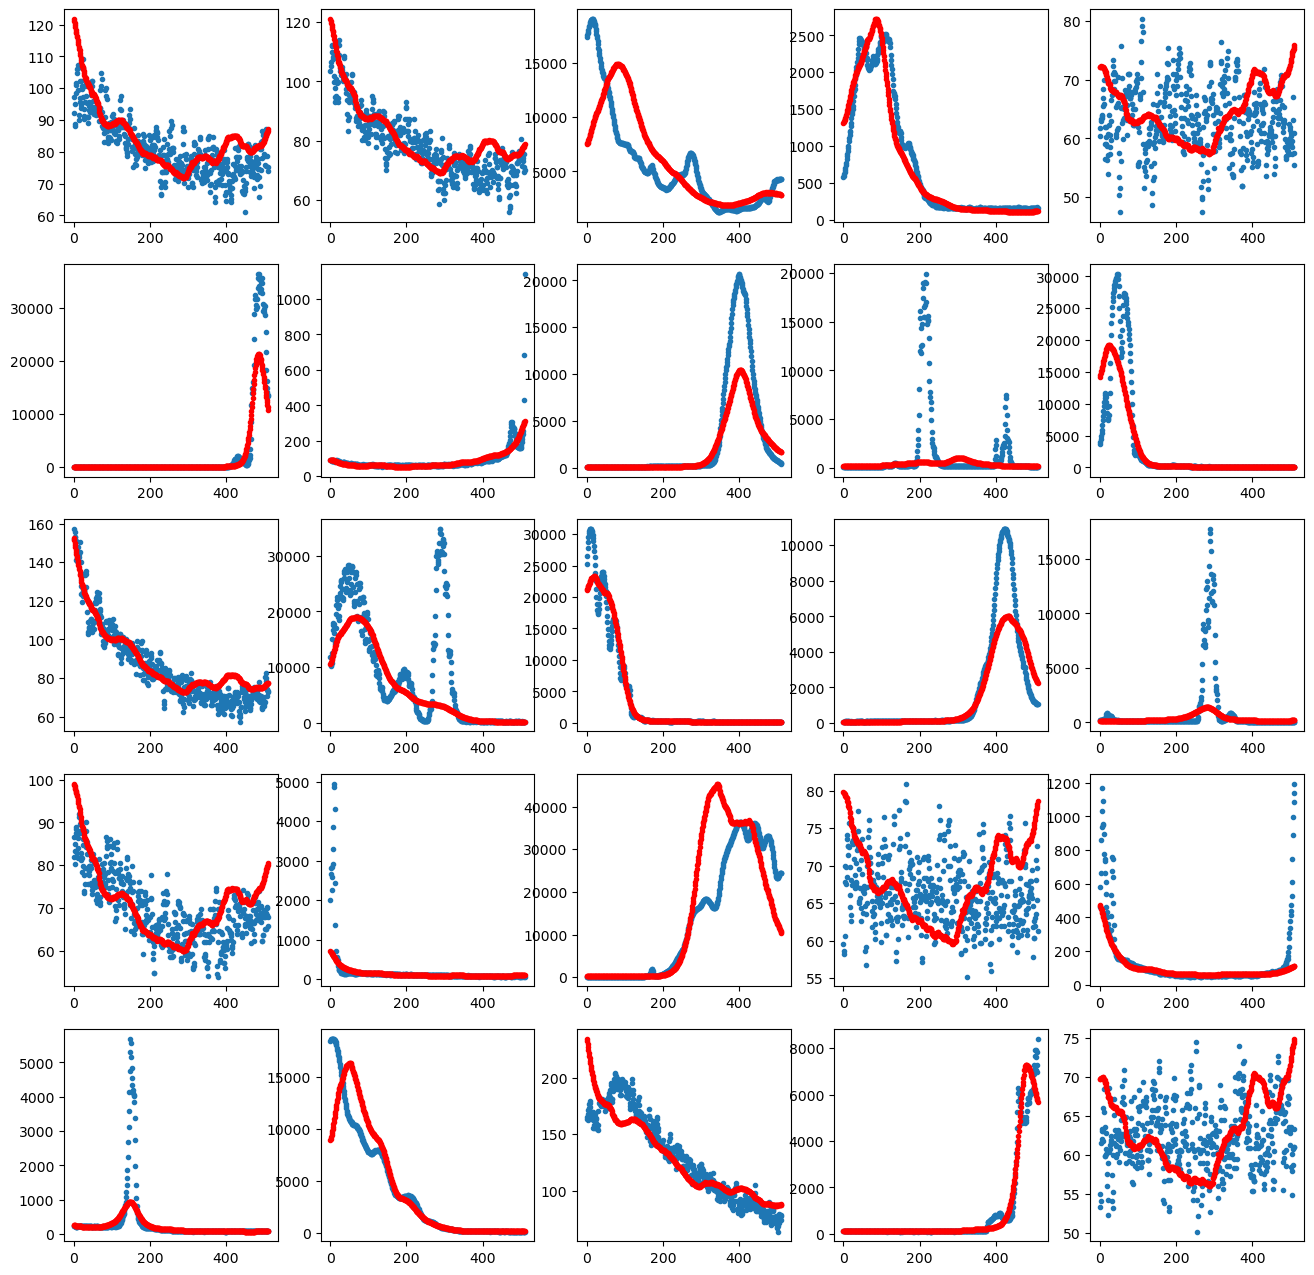

In [20]:
fig, axs = plt.subplots(5,5,figsize=(16,16))

for i in range(5):
    for j in range(5):
        ind = np.random.randint(len(y_test))
        axs[i,j].scatter(x,10**(X_test[ind]),marker='.')
        axs[i,j].scatter(x,10**(X_pred[ind]),color="red",marker='.');

(512,)
512


ValueError: in user code:

    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/mchobola/anaconda3/envs/envi/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 1024 but received input with shape (32, 8)


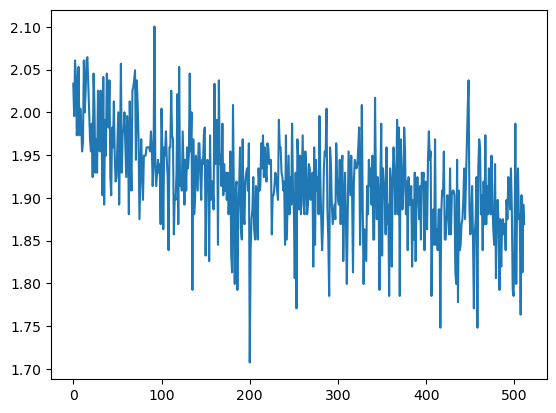

In [38]:
def isModelGood(model,windowSize):
    grbs = glob.glob("Data/scaled_xyzlog_512-128_64/*.csv")
    for n , grb in enumerate(grbs):
        df = pd.read_csv(grb, index_col=0)
        num_df = df.to_numpy()
        df = df.drop(['0'],axis=1)
        X0 = tf.convert_to_tensor(df.to_numpy()[-windowSize:,-1])
        plt.plot(X0)
        print(np.shape(X0))
        print(len(X0))
        pred, true = [],[]
        pred.append(model.predict(X0))
        true.append(X0)
    return true, pred
true, pred = isModelGood(autoencoder,512)

TypeError: '(slice(-512, None, None), -1)' is an invalid key

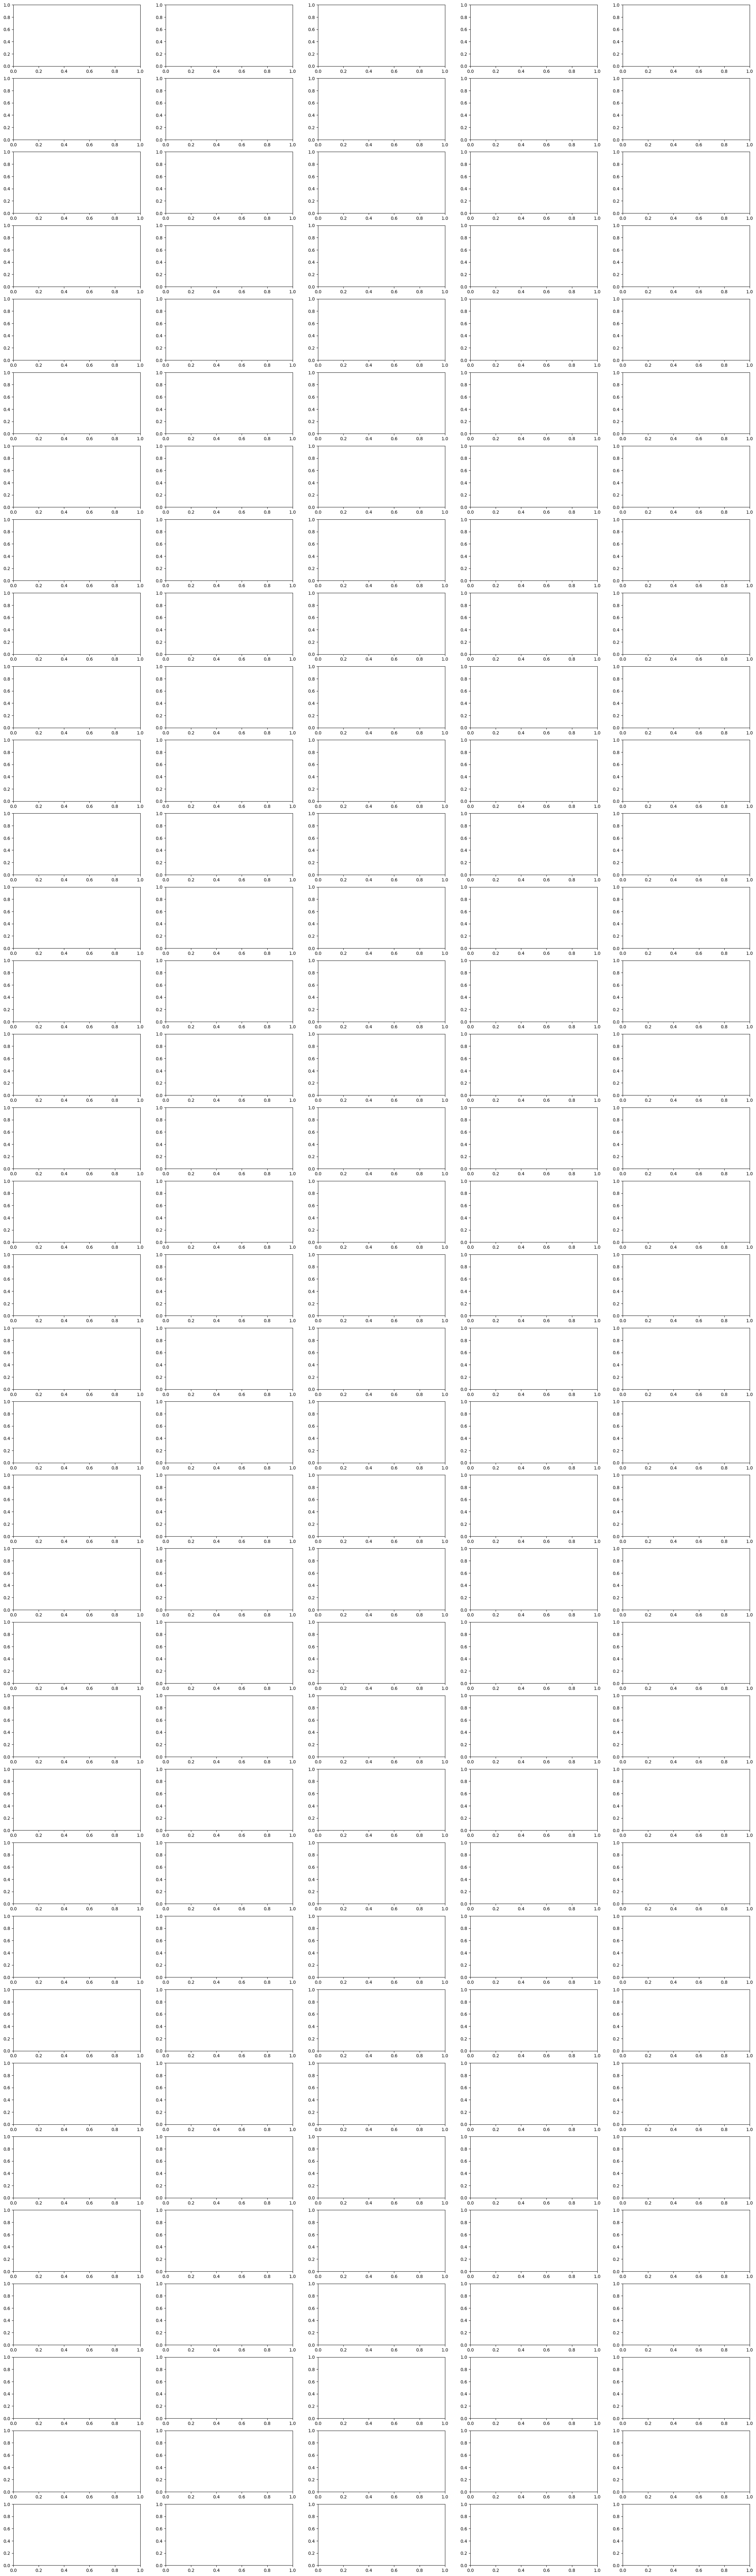

In [15]:
#autoencoder.save("autoencoder_conv1d")